The root file associated with this notebook contains jets from $t\bar{t}h \to bb$ and $Z' \to b\bar{b}$

# Imports and Variable Definitions

In [1]:
import uproot
import numpy as np
import awkward as ak
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import bcml4pheno
import scipy
import math
import matplotlib.pyplot as plt
from timeit import default_timer as timer

In [2]:
# variables we want histos for
orig_variables = ['jet_pt', 'jet_eta',
    'nCpfcand','nNpfcand',
    'nsv','npv',
    'TagVarCSV_trackSumJetEtRatio',
    'TagVarCSV_trackSumJetDeltaR',
    'TagVarCSV_vertexCategory',
    'TagVarCSV_trackSip2dValAboveCharm',
    'TagVarCSV_trackSip2dSigAboveCharm',
    'TagVarCSV_trackSip3dValAboveCharm',
    'TagVarCSV_trackSip3dSigAboveCharm',
    'TagVarCSV_jetNSelectedTracks',
    'TagVarCSV_jetNTracksEtaRel'] + ['Cpfcan_BtagPf_trackEtaRel',
    'Cpfcan_BtagPf_trackPtRel',
    'Cpfcan_BtagPf_trackPPar',
    'Cpfcan_BtagPf_trackDeltaR',
    'Cpfcan_BtagPf_trackPParRatio',
    'Cpfcan_BtagPf_trackSip2dVal',
    'Cpfcan_BtagPf_trackSip2dSig',
    'Cpfcan_BtagPf_trackSip3dVal',
    'Cpfcan_BtagPf_trackSip3dSig',
    'Cpfcan_BtagPf_trackJetDistVal',
    'Cpfcan_ptrel',
    'Cpfcan_drminsv',
    'Cpfcan_VTX_ass',
    'Cpfcan_puppiw',
    'Cpfcan_chi2',
    'Cpfcan_quality'] + ['Npfcan_ptrel',
    'Npfcan_deltaR','Npfcan_isGamma',
    'Npfcan_HadFrac','Npfcan_drminsv',
    'Npfcan_puppiw'] + ['sv_pt','sv_deltaR',
    'sv_mass',
    'sv_ntracks',
    'sv_chi2',
    'sv_normchi2',
    'sv_dxy',
    'sv_dxysig',
    'sv_d3d',
    'sv_d3dsig',
    'sv_costhetasvpv',
    'sv_enratio']
new_variables = [
    'numberOfValidHits',
    'numberOfValidTrackerHits',
    'numberOfValidPixelHits',
    'numberOfValidPixelBarrelHits',
    'numberOfValidPixelEndcapHits',
    'numberOfValidStripHits',
    'numberOfValidStripTIBHits',
    'numberOfValidStripTIDHits',
    'numberOfValidStripTOBHits',
    'numberOfValidStripTECHits',
    'numberOfMuonHits',
    'numberOfValidMuonHits',
    'numberOfValidMuonDTHits',
    'numberOfValidMuonCSCHits',
    'numberOfValidMuonRPCHits',
    'numberOfValidMuonGEMHits',
    'numberOfValidMuonME0Hits',
    'numberOfLostMuonHits',
    'numberOfLostMuonDTHits',
    'numberOfLostMuonCSCHits',
    'numberOfLostMuonRPCHits',
    'numberOfLostMuonGEMHits',
    'numberOfLostMuonME0Hits',
    'numberOfBadHits',
    'numberOfBadMuonHits',
    'numberOfBadMuonDTHits',
    'numberOfBadMuonCSCHits',
    'numberOfBadMuonRPCHits',
    'numberOfBadMuonGEMHits',
    'numberOfBadMuonME0Hits',
    'numberOfInactiveHits',
    'numberOfInactiveTrackerHits',
    'numberOfValidStripLayersWithMonoAndStereo',
    'numberOfValidTOBLayersWithMonoAndStereo',
    'numberOfValidTIBLayersWithMonoAndStereo',
    'numberOfValidTIDLayersWithMonoAndStereo',
    'numberOfValidTECLayersWithMonoAndStereo',
    'trackerLayersWithMeasurementOld',
    'trackerLayersWithMeasurement',
    'pixelLayersWithMeasurementOld',
    'pixelLayersWithMeasurement',
    'stripLayersWithMeasurement',
    'pixelBarrelLayersWithMeasurement',
    'pixelEndcapLayersWithMeasurement',
    'stripTIBLayersWithMeasurement',
    'stripTIDLayersWithMeasurement',
    'stripTOBLayersWithMeasurement',
    'stripTECLayersWithMeasurement',
    'trackerLayersTotallyOffOrBad',
    'pixelLayersTotallyOffOrBad',
    'stripLayersTotallyOffOrBad',
    'pixelBarrelLayersTotallyOffOrBad',
    'pixelEndcapLayersTotallyOffOrBad',
    'stripTIBLayersTotallyOffOrBad',
    'stripTIDLayersTotallyOffOrBad',
    'stripTOBLayersTotallyOffOrBad',
    'stripTECLayersTotallyOffOrBad',
    'trackerLayersNull',
    'pixelLayersNull',
    'stripLayersNull',
    'pixelBarrelLayersNull',
    'pixelEndcapLayersNull',
    'stripTIBLayersNull',
    'stripTIDLayersNull',
    'stripTOBLayersNull',
    'stripTECLayersNull',
]
total_variables = orig_variables + new_variables

In [3]:
# aesthetic matplotlib settings
settings = {'axes.labelsize': 32,
            'axes.titlesize' : 40,
            'figure.titlesize' : 40,
            'xtick.major.size': 10,
            'xtick.major.width': 1.5,
            'xtick.labelsize': 24,
            'ytick.major.size': 10,
            'ytick.major.width': 1.5,
            'ytick.labelsize': 24,
            'legend.fontsize': 18,
            'axes.titlesize': 48,
            'lines.linewidth': 4,
            'lines.markersize': 10,
            'figure.figsize': (15,10)}

# ROOT -> Numpy Functions

Accepts 2D awkward array `array` (2nd axis is variable length), extends each row with `value` until it is at least length `target`.

In [4]:
def pad(array, target, value=-100):
    # note default axis of pad_none, fill_none = 1
    return ak.fill_none(ak.pad_none(array, target=target), value=value, axis=None)

In [5]:
# could use some optimization: pass lists of indices of scalar vars, vector vars, and do all at once?
def dataFromROOT(root_file, sort_var, variables, key, N=5):
    with uproot.open(root_file) as file:
        tree = file[key]
        data = [ak.to_numpy(tree[variables[0]].array())] # using the fact that first, jet_pt, is scalar
        length = data[0].shape[0]
        max_tracks = ak.max(tree['nCpfcand'].array()) # ith element is num. constituents in jet -> length of vector-valued vars
        impact_params = pad(tree[sort_var].array(), target=max_tracks, value=0) # num. jets x max_tracks, impact parameters padded with 0
        indices = np.argsort(-np.abs(ak.to_numpy(impact_params)))[:,:N] # num. jets x N, each row is indices of N constituents with greatest impact parameters
        # stacking on data, variable by variable
        for variables in variables[1:]:
            if type(tree[variables].array()[0]) == ak.highlevel.Array:
                data = np.concatenate(
                    (data, 
                     [ak.to_numpy(pad(tree[variables].array(), target=max_tracks)[np.arange(0,length,1),row]) 
                      for row in np.transpose(indices)]))
            else:
                data = np.concatenate((data, [ak.to_numpy(tree[variables].array())]))
    return np.transpose(data) # want rows to be jets, not variables

In [6]:
def getFeatureNames(root_file, key, variables, N=5):
    scalar = []
    vector = []
    with uproot.open(root_file) as file:
        tree = file[key]
        for var in variables:
            if type(tree[var].array()[0]) == ak.highlevel.Array:
                vector.append(var)
            else:
                scalar.append(var)

    ml_feature_names = []
    for var in variables:
        if var in scalar:
            ml_feature_names.append(var)
        else:
            ml_feature_names.extend([var + f'_{i+1}' for i in range(N)])
    print(f'scalar: {len(scalar)}, vector: {len(vector)}')
    return ml_feature_names

In [7]:
def getSigBgIndices(root_file, key):
    with uproot.open(root_file) as file:
        tree = file[key]
        sigInd = np.where(tree['isB'].array() == 1)[0]
        bgInd = np.concatenate(
                (np.where(tree['isG'].array() == 1)[0], 
                 np.where(tree['isUD'].array() == 1)[0],
                 np.where(tree['isS'].array() == 1)[0]))
    return [sigInd, bgInd]

# Importing/Setting Up Data

In [8]:
root_file = 'ttHJetTobb_18Feb22_hitpatterVars_3X_zprrime2TeVTobb_18Feb22_hitpatterVars_ALL.root'
N = 5

In [9]:
t1 = timer()
with uproot.open(root_file) as file:
    keys = file.keys()
    print(f'Keys in ROOT file: {keys}')
    key = keys[1]
    print(f'Number of variables in file["{key}"]: {len(file[key])}')
    vector_vars = [k for k in file[key].keys() if type(file[key][k].array()[0]) == ak.highlevel.Array]
    scalar_vars = [k for k in file[key].keys() if k not in vector_vars]
    print(f'Number of scalar variables: {len(scalar_vars)}')
    print(f'Number of (variable-length) vector variables: {len(vector_vars)}')
    print(f'Number of features if {N} scalars kept from each vector variable: {len(scalar_vars) + N * len(vector_vars)}')
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

Keys in ROOT file: ['deepntuplizer;1', 'deepntuplizer/tree;1']
Number of variables in file["deepntuplizer/tree;1"]: 260
Number of scalar variables: 88
Number of (variable-length) vector variables: 172
Number of features if 5 scalars kept from each vector variable: 948
duration: 0.74 min


In [10]:
for name, variables in zip(['orig', 'new', 'total'], [orig_variables, new_variables, total_variables]):
    scalar_vars_subset = [k for k in scalar_vars if k in variables]
    vector_vars_subset = [k for k in vector_vars if k in variables]
    print(f'Num. variables in {name}_variables: {len(variables)}')
    print(f'Num. scalar variables in {name}_variables: {len(scalar_vars_subset)}')
    print(f'Num. vector variables in {name}_variables: {len(vector_vars_subset)}')
    print(f'Num. of features if {N} scalars kept from each vector variable: {len(scalar_vars_subset) + N * len(vector_vars_subset)}')
    print()

Num. variables in orig_variables: 49
Num. scalar variables in orig_variables: 15
Num. vector variables in orig_variables: 34
Num. of features if 5 scalars kept from each vector variable: 185

Num. variables in new_variables: 66
Num. scalar variables in new_variables: 0
Num. vector variables in new_variables: 66
Num. of features if 5 scalars kept from each vector variable: 330

Num. variables in total_variables: 115
Num. scalar variables in total_variables: 15
Num. vector variables in total_variables: 100
Num. of features if 5 scalars kept from each vector variable: 515



In [11]:
t1 = timer()
data = dataFromROOT(root_file=root_file, 
                    sort_var='Cpfcan_BtagPf_trackSip2dVal', # impact parameter
                    variables=total_variables,
                    key=key,
                    N=N)
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

/Users/sheridan/opt/anaconda3/envs/pheno/lib/python3.9/site-packages/awkward/operations/structure.py:2688: DeprecationWarning: an integer is required (got type numpy.float32).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  out = layout.rpad(target, axis)


duration: 19.89 min


In [12]:
print(f'shape of data: {data.shape}')

shape of data: (1806792, 515)


In [13]:
def getFeatureNames(scalar_vars, variables, N=5):
    feature_names = []
    for var in variables:
        if var in scalar_vars:
            feature_names.append(var)
        else:
            feature_names.extend([var + f'_{i+1}' for i in range(N)])
    return feature_names

In [14]:
orig_feature_names = getFeatureNames(scalar_vars, orig_variables, N=5)
new_feature_names = getFeatureNames(scalar_vars, new_variables, N=5)
total_feature_names = getFeatureNames(scalar_vars, total_variables, N=5)
print(f'Num. names of features from total_variables: {len(total_feature_names)}')

Num. names of features from total_variables: 515


In [15]:
sigInd, bgInd = getSigBgIndices(root_file, key)

In [16]:
sig = data[sigInd]
bg = data[bgInd]

In [17]:
X = np.concatenate((sig[:,:len(orig_feature_names)], bg[:,:len(orig_feature_names)]))
Y = np.concatenate((np.ones(sig.shape[0]), np.zeros(bg.shape[0])))

In [18]:
print(f'shape of predictors: {X.shape}')
print(f'shape of signal jets: {X[Y == 1].shape}')
print(f'shape of background jets: {X[Y == 0].shape}')
print(f'shape of labels: {Y.shape}')

shape of predictors: (1310007, 185)
shape of signal jets: (486342, 185)
shape of background jets: (823665, 185)
shape of labels: (1310007,)


Trimming X to contain equal amounts of signal, background

In [19]:
evenX = np.concatenate([X[Y==1], (X[Y==0])[:np.sum(Y==1)]], axis=0)
evenY = np.concatenate([Y[Y==1], (Y[Y==0])[:np.sum(Y==1)]], axis=0)
print(f'shape of new, even predictors: {evenX.shape}')
print(f'(wanted a length of {np.sum(Y==1)*2})')

shape of new, even predictors: (972684, 185)
(wanted a length of 972684)


# Understanding $p_T$ + Flat $p_T$ Data Preparation

In [20]:
print(f'min pT = {round(np.amin(X[:,0]),3)} GeV, max pT = {round(np.amax(X[:,0]),3)} GeV (signal + background)')
print(f'min pT = {round(np.amin(X[Y==1,0]),3)} GeV, max pT = {round(np.amax(X[Y==1,0]),3)} GeV (signal)')
print(f'min pT = {round(np.amin(X[Y==0,0]),3)} GeV, max pT = {round(np.amax(X[Y==0,0]),3)} GeV (background)')

min pT = 14.399 GeV, max pT = 948.367 GeV (signal + background)
min pT = 14.629 GeV, max pT = 948.367 GeV (signal)
min pT = 14.399 GeV, max pT = 945.904 GeV (background)


In [21]:
bins = np.arange(0, 1000, 40)
print(f'Number of bins: {len(bins) - 1}')

Number of bins: 24


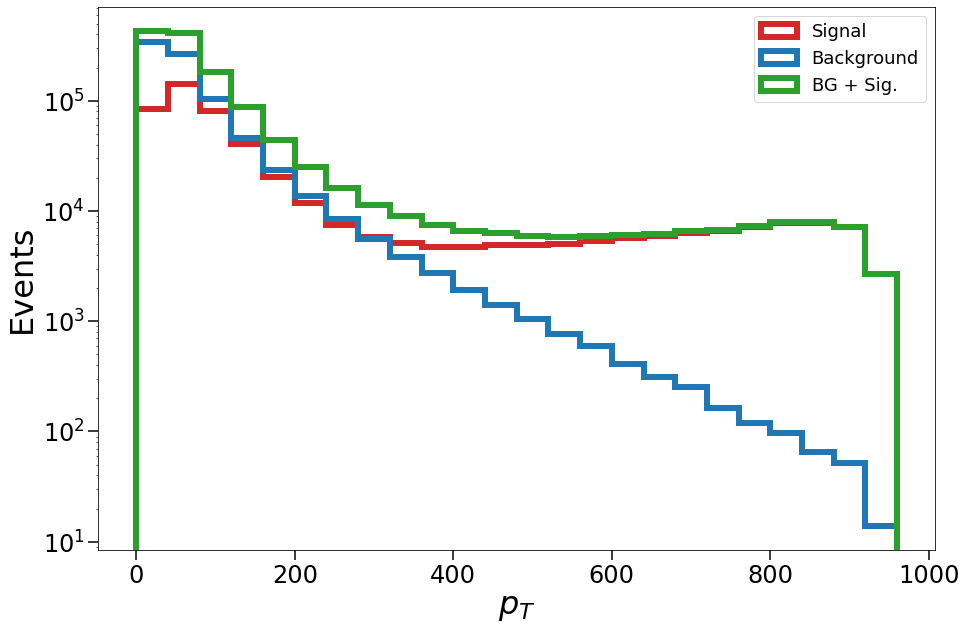

In [92]:
with plt.rc_context(settings):
    # pt_hist is 3 x len(bins) - 1, rows are signal/bg and cols are heights of histogram for each bin
    pt_hist, _, _ = plt.hist(
        [X[:, 0], X[Y==0, 0], X[Y==1,0]], 
        bins=bins, 
        histtype='step', 
        label=['BG + Sig.', 'Background', 'Signal'], 
        color=['tab:green', 'tab:blue', 'tab:red'],
        linewidth=6)
    plt.legend()
    plt.xlabel(r'$p_T$')
    plt.ylabel(r'Events')
    plt.yscale('log')
#     plt.savefig(f'./gbdt_images/three_cases/flat_pt_pt_dist', dpi=200, bbox_inches='tight')

Note that the second to last bin is substantially lower than all of the others: we choose to drop that bin and flatten $p_T$ to the smallest bin aside from that one.

In [93]:
all_pt_hist, bg_pt_hist, sig_pt_hist = pt_hist
binInds = np.digitize(X[:,0], bins) # 1D, len = len of X, element gives index of pT bin for that jet (starting at 1)

In [24]:
def produceFlatPtData(X, Y, sigInd, bgInd, binInds, perBin, lowIndex, highIndex):
    flatPtX = []
    flatPtY = []
    for i in range(np.amin(binInds), np.amax(binInds)):
        if np.sum((Y == 1) & (binInds == i)) > np.sum((Y == 0) & (binInds == i)):
            numBg = min(int(perBin/2), np.sum((Y == 0) & (binInds == i)))
            flatPtX.append((X[(Y == 1) & (binInds == i)])[:perBin-numBg])
            flatPtX.append((X[(Y == 0) & (binInds == i)])[:numBg])
            flatPtY.append(np.ones(perBin-numBg))
            flatPtY.append(np.zeros(numBg))
        else:
            numSig = min(int(perBin/2), np.sum((Y == 1) & (binInds == i)))
            flatPtX.append((X[(Y == 1) & (binInds == i)])[:numSig])
            flatPtX.append((X[(Y == 0) & (binInds == i)])[:perBin-numSig])
            flatPtY.append(np.ones(numSig))
            flatPtY.append(np.zeros(perBin-numSig))
    return [np.concatenate(flatPtX, axis=0), np.concatenate(flatPtY, axis=0)]

In [25]:
perBin = int(np.amin(all_pt_hist[:-1]))
print(f'Jets sampled per bin: {perBin}')
flatPtX, flatPtY = produceFlatPtData(X, Y, sigInd, bgInd, binInds, perBin, np.amin(binInds), np.amax(binInds)-1)

Jets sampled per bin: 5831


In [26]:
print(f'Shape of flatPtX: {flatPtX.shape}')
print(f'Shape of flatPtX: {flatPtY.shape}')
print(f'(We expected {perBin * ((np.amax(binInds)-1) - np.amin(binInds) + 1)} jets)')

Shape of flatPtX: (134113, 185)
Shape of flatPtX: (134113,)
(We expected 134113 jets)


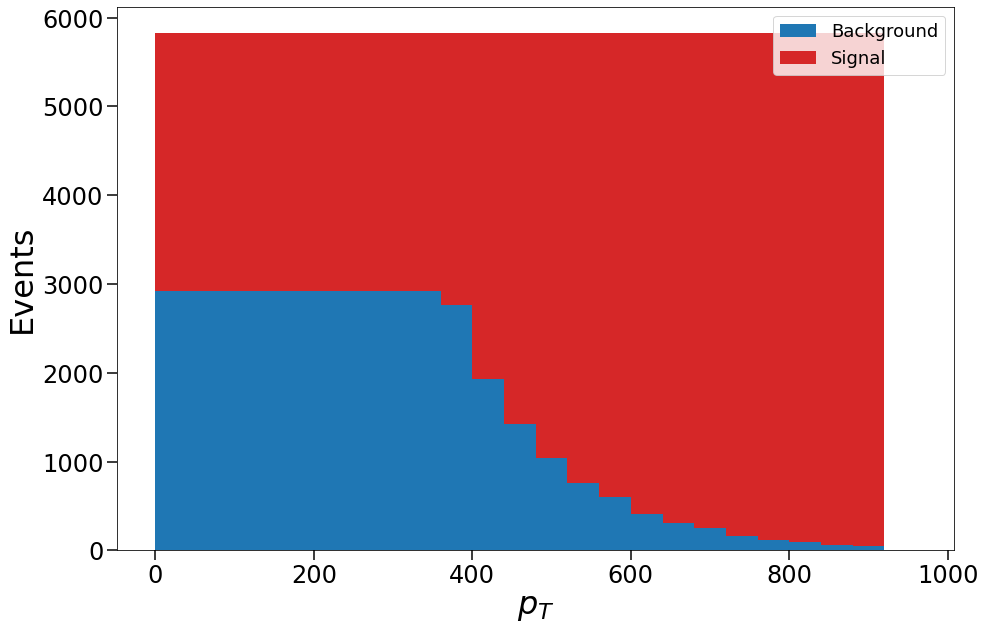

In [91]:
with plt.rc_context(settings):
    flat_pt_hist, _, _ = plt.hist(
        [flatPtX[flatPtY==0, 0], flatPtX[flatPtY==1, 0]], 
        bins=bins, 
        histtype='barstacked', 
        label=['Background', 'Signal'], 
        color=['tab:blue', 'tab:red'],
        linewidth=6)
    plt.legend()
    plt.xlabel(r'$p_T$')
    plt.ylabel(r'Events')
#     plt.savefig(f'./gbdt_images/three_cases/flat_pt_pt_dist', dpi=200, bbox_inches='tight')

In [88]:
flatPtBinInds = np.digitize(flatPtX[:,0], bins)

Maybe consider $p_T$ for our evenX data?

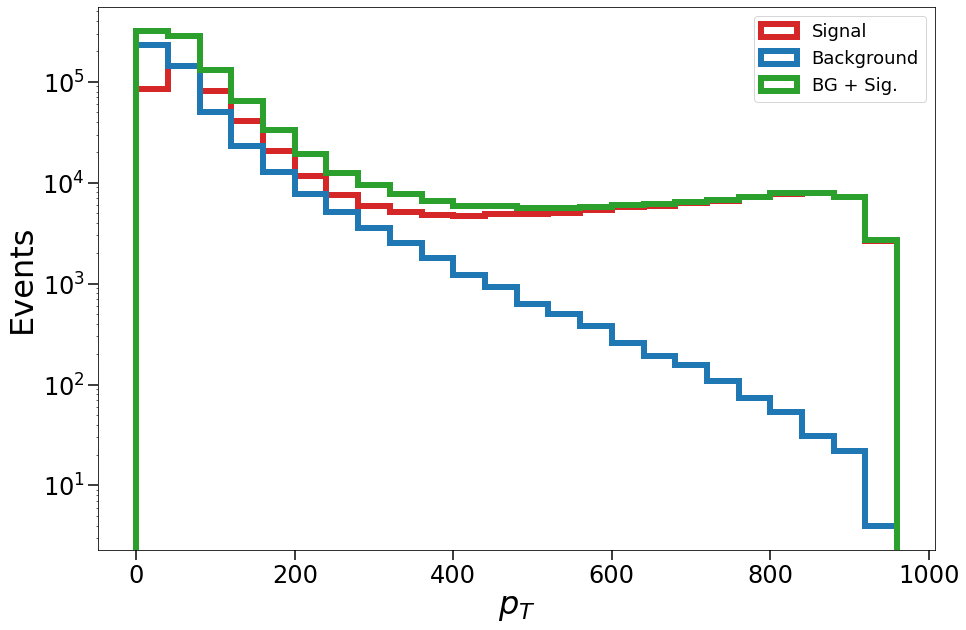

In [29]:
with plt.rc_context(settings):
    # pt_hist is 3 x len(bins) - 1, rows are signal/bg and cols are heights of histogram for each bin
    even_pt_hist, _, _ = plt.hist(
        [evenX[:, 0], evenX[evenY==0, 0], evenX[evenY==1,0]], 
        bins=bins, 
        histtype='step', 
        label=['BG + Sig.', 'Background', 'Signal'], 
        color=['tab:green', 'tab:blue', 'tab:red'],
        linewidth=6)
    plt.legend()
    plt.xlabel(r'$p_T$')
    plt.ylabel(r'Events')
    plt.yscale('log')
#     plt.savefig(f'./gbdt_images/three_cases/flat_pt_pt_dist', dpi=200, bbox_inches='tight')

In [89]:
even_all_pt_hist, even_bg_pt_hist, even_sig_pt_hist = even_pt_hist
evenBinInds = np.digitize(evenX[:,0], bins) # 1D, len = len of X, element gives index of pT bin for that jet (starting at 1)

# Producing jet weights

Idea: weight each jet such that 1) sum over weights = # of jet and 2) weight $\propto \frac{1}{\text{height of bin in } p_T \text{ dist.}}$ (emulating a flat $p_T$ distribution)

In [31]:
binWeights = np.array([len(X)/(height * len(all_pt_hist)) for height in all_pt_hist])
weights = [binWeights[bin_num - 1] for bin_num in binInds]

In [32]:
print(f'Sum over weights: {int(np.sum(weights))}')
print(f'(Wanted this to be {X.shape[0]})')

Sum over weights: 1310007
(Wanted this to be 1310007)


Might want to consider weighting signal, background separately, such that weights sum to 50% for both signal and background

In [33]:
print(np.sum(even_sig_pt_hist))
print(np.sum(evenY==1))

486342.0
486342


In [34]:
sigEvenBinWeights = np.array([np.sum(evenY==1)/(height * len(even_sig_pt_hist)) for height in even_sig_pt_hist])
bgEvenBinWeights = np.array([np.sum(evenY==0)/(height * len(even_bg_pt_hist)) for height in even_bg_pt_hist])
evenWeights = np.array([bgEvenBinWeights[bin_num - 1] if y == 0 else sigEvenBinWeights[bin_num - 1] for bin_num, y in zip(evenBinInds, evenY)])

In [35]:
print(f'Sum over weights: {int(np.sum(evenWeights))}')
print(f'(Wanted this to be {evenX.shape[0]})')
print(f'Sum over signal weights: {int(np.sum(evenWeights[evenY==1]))}')
print(f'(Wanted this to be {np.sum(evenY==1)})')
print(f'Sum over background weights: {int(np.sum(evenWeights[evenY==0]))}')
print(f'(Wanted this to be {np.sum(evenY==0)})')

Sum over weights: 972684
(Wanted this to be 972684)
Sum over signal weights: 486341
(Wanted this to be 486342)
Sum over background weights: 486342
(Wanted this to be 486342)


# Training Models

In [110]:
X_train, X_test, Y_train, Y_test, weights_train, weights_test, binInds_train, binInds_test = train_test_split(
    X, Y, weights, binInds, random_state=0)

In [111]:
flatPt_X_train, flatPt_X_test, flatPt_Y_train, flatPt_Y_test, flatPt_binInds_train, flatPt_binInds_test \
    = train_test_split(flatPtX, flatPtY, flatPtBinInds, random_state=0)

In [105]:
even_X_train, even_X_test, even_Y_train, even_Y_test, even_weights_train, even_weights_test, even_binInds_train, \
    even_binInds_test = train_test_split(evenX, evenY, evenWeights, evenBinInds, random_state=0)

In [65]:
t1 = timer()
raw_model = make_pipeline(
    StandardScaler(), 
    XGBClassifier(nthread=4, use_label_encoder=False, n_estimators=100));
raw_model.fit(X_train, Y_train, xgbclassifier__verbose=True, xgbclassifier__eval_set=[(X_test, Y_test)])
model = bcml4pheno.bcml_model(raw_model)
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

[0]	validation_0-logloss:0.74655
[1]	validation_0-logloss:0.81870
[2]	validation_0-logloss:0.81598
[3]	validation_0-logloss:0.84826
[4]	validation_0-logloss:0.85356
[5]	validation_0-logloss:0.92456
[6]	validation_0-logloss:0.91961
[7]	validation_0-logloss:0.93885
[8]	validation_0-logloss:0.86938
[9]	validation_0-logloss:0.89795
[10]	validation_0-logloss:0.93577
[11]	validation_0-logloss:1.00471
[12]	validation_0-logloss:0.98537
[13]	validation_0-logloss:0.82649
[14]	validation_0-logloss:0.89768
[15]	validation_0-logloss:0.90488
[16]	validation_0-logloss:0.88996
[17]	validation_0-logloss:0.92726
[18]	validation_0-logloss:0.88928
[19]	validation_0-logloss:0.83565
[20]	validation_0-logloss:0.85615
[21]	validation_0-logloss:0.85350
[22]	validation_0-logloss:0.86265
[23]	validation_0-logloss:0.85646
[24]	validation_0-logloss:0.86379
[25]	validation_0-logloss:0.86273
[26]	validation_0-logloss:0.94593
[27]	validation_0-logloss:0.95792
[28]	validation_0-logloss:0.97510
[29]	validation_0-loglos

In [66]:
t1 = timer()
even_raw_model = make_pipeline(
    StandardScaler(), 
    XGBClassifier(nthread=4, use_label_encoder=False, n_estimators=100));
even_raw_model.fit(even_X_train, even_Y_train, xgbclassifier__verbose=True, 
                   xgbclassifier__eval_set=[(even_X_test, even_Y_test)])
even_model = bcml4pheno.bcml_model(even_raw_model)
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

[0]	validation_0-logloss:0.71261
[1]	validation_0-logloss:0.70805
[2]	validation_0-logloss:0.74298
[3]	validation_0-logloss:0.81473
[4]	validation_0-logloss:0.85865
[5]	validation_0-logloss:0.93526
[6]	validation_0-logloss:0.90201
[7]	validation_0-logloss:0.95471
[8]	validation_0-logloss:0.99626
[9]	validation_0-logloss:0.97509
[10]	validation_0-logloss:0.98453
[11]	validation_0-logloss:0.96919
[12]	validation_0-logloss:0.98761
[13]	validation_0-logloss:0.98406
[14]	validation_0-logloss:0.98277
[15]	validation_0-logloss:0.97485
[16]	validation_0-logloss:0.95222
[17]	validation_0-logloss:1.01853
[18]	validation_0-logloss:1.02248
[19]	validation_0-logloss:1.10025
[20]	validation_0-logloss:1.10181
[21]	validation_0-logloss:1.11207
[22]	validation_0-logloss:1.23118
[23]	validation_0-logloss:1.19818
[24]	validation_0-logloss:1.20612
[25]	validation_0-logloss:1.20296
[26]	validation_0-logloss:1.22015
[27]	validation_0-logloss:1.26726
[28]	validation_0-logloss:1.28854
[29]	validation_0-loglos

In [67]:
t1 = timer()
flatPt_raw_model = make_pipeline(
    StandardScaler(), 
    XGBClassifier(nthread=4, use_label_encoder=False, n_estimators=100));
flatPt_raw_model.fit(flatPt_X_train, flatPt_Y_train, xgbclassifier__verbose=True, 
                     xgbclassifier__eval_set=[(flatPt_X_test, flatPt_Y_test)])
flatPT_model = bcml4pheno.bcml_model(flatPt_raw_model)
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

[0]	validation_0-logloss:0.60813
[1]	validation_0-logloss:0.58721
[2]	validation_0-logloss:0.56968
[3]	validation_0-logloss:0.59080
[4]	validation_0-logloss:0.61176
[5]	validation_0-logloss:0.62733
[6]	validation_0-logloss:0.64529
[7]	validation_0-logloss:0.64923
[8]	validation_0-logloss:0.66674
[9]	validation_0-logloss:0.63265
[10]	validation_0-logloss:0.63439
[11]	validation_0-logloss:0.66562
[12]	validation_0-logloss:0.62322
[13]	validation_0-logloss:0.64599
[14]	validation_0-logloss:0.65400
[15]	validation_0-logloss:0.63712
[16]	validation_0-logloss:0.66997
[17]	validation_0-logloss:0.65681
[18]	validation_0-logloss:0.65016
[19]	validation_0-logloss:0.65764
[20]	validation_0-logloss:0.65779
[21]	validation_0-logloss:0.67198
[22]	validation_0-logloss:0.66470
[23]	validation_0-logloss:0.65932
[24]	validation_0-logloss:0.67044
[25]	validation_0-logloss:0.68074
[26]	validation_0-logloss:0.65190
[27]	validation_0-logloss:0.66930
[28]	validation_0-logloss:0.65942
[29]	validation_0-loglos

In [68]:
t1 = timer()
weighted_raw_model = make_pipeline(
    StandardScaler(), 
    XGBClassifier(nthread=4, use_label_encoder=False, n_estimators=100));
weighted_raw_model.fit(X_train, Y_train, xgbclassifier__sample_weight=weights_train, xgbclassifier__verbose=True, 
                       xgbclassifier__eval_set=[(X_test, Y_test)])
weighted_model = bcml4pheno.bcml_model(weighted_raw_model)
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

[0]	validation_0-logloss:0.80563
[1]	validation_0-logloss:0.86491
[2]	validation_0-logloss:0.88631
[3]	validation_0-logloss:1.00748
[4]	validation_0-logloss:1.12778
[5]	validation_0-logloss:1.08490
[6]	validation_0-logloss:1.20168
[7]	validation_0-logloss:1.05721
[8]	validation_0-logloss:1.12897
[9]	validation_0-logloss:0.96978
[10]	validation_0-logloss:0.96548
[11]	validation_0-logloss:0.97291
[12]	validation_0-logloss:1.03395
[13]	validation_0-logloss:0.99831
[14]	validation_0-logloss:1.04700
[15]	validation_0-logloss:1.03290
[16]	validation_0-logloss:1.22462
[17]	validation_0-logloss:1.29162
[18]	validation_0-logloss:1.34121
[19]	validation_0-logloss:1.59983
[20]	validation_0-logloss:1.69420
[21]	validation_0-logloss:1.72826
[22]	validation_0-logloss:1.74473
[23]	validation_0-logloss:1.70828
[24]	validation_0-logloss:1.71893
[25]	validation_0-logloss:1.75200
[26]	validation_0-logloss:1.72615
[27]	validation_0-logloss:2.07095
[28]	validation_0-logloss:2.13560
[29]	validation_0-loglos

In [69]:
t1 = timer()
weighted_even_raw_model = make_pipeline(
    StandardScaler(), 
    XGBClassifier(nthread=4, use_label_encoder=False, n_estimators=100));
weighted_even_raw_model.fit(even_X_train, even_Y_train, xgbclassifier__sample_weight=even_weights_train, 
                            xgbclassifier__verbose=True, 
                            xgbclassifier__eval_set=[(even_X_test, even_Y_test)])
weighted_even_model = bcml4pheno.bcml_model(weighted_even_raw_model)
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

[0]	validation_0-logloss:0.64985
[1]	validation_0-logloss:0.75008
[2]	validation_0-logloss:0.82374
[3]	validation_0-logloss:0.77897
[4]	validation_0-logloss:0.83149
[5]	validation_0-logloss:0.83523
[6]	validation_0-logloss:0.82811
[7]	validation_0-logloss:0.83199
[8]	validation_0-logloss:0.80787
[9]	validation_0-logloss:0.86546
[10]	validation_0-logloss:0.84991
[11]	validation_0-logloss:0.90380
[12]	validation_0-logloss:1.02761
[13]	validation_0-logloss:1.28683
[14]	validation_0-logloss:1.84766
[15]	validation_0-logloss:2.00009
[16]	validation_0-logloss:2.17205
[17]	validation_0-logloss:2.17471
[18]	validation_0-logloss:2.17622
[19]	validation_0-logloss:2.30753
[20]	validation_0-logloss:2.64750
[21]	validation_0-logloss:2.78494
[22]	validation_0-logloss:2.78601
[23]	validation_0-logloss:2.83477
[24]	validation_0-logloss:2.93456
[25]	validation_0-logloss:2.91489
[26]	validation_0-logloss:3.12067
[27]	validation_0-logloss:3.38252
[28]	validation_0-logloss:3.54967
[29]	validation_0-loglos

# Visualization Functions

In [39]:
def mlHisto(model, X_train, X_test, Y_train, Y_test):
    with plt.rc_context(settings):
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(24, 12))
        bin_edges, sig_bins_train, bg_bins_train = model.predict_hist(X_train, Y_train, num_bins=40)
        bin_edges, sig_bins_test, bg_bins_test = model.predict_hist(X_test, Y_test, num_bins=40)
        axes[0].bar(bin_edges[:-1], sig_bins_train, width=np.diff(bin_edges), alpha=0.75, align="edge", 
                    label="Signal (Train)", color='tab:blue')
        axes[0].bar(bin_edges[:-1], bg_bins_train, width=np.diff(bin_edges), alpha=0.75, align="edge", 
                    label="BG (Train)", color='gray')
        axes[1].bar(bin_edges[:-1], sig_bins_test, width=np.diff(bin_edges), alpha=0.75, align="edge", 
                    label="Signal (Test)", color='tab:red')
        axes[1].bar(bin_edges[:-1], bg_bins_test, width=np.diff(bin_edges), alpha=0.75, align="edge", 
                    label="BG (Test)", color='gray')
        for axis in axes:
            axis.set_yscale('log')
            axis.set_ylim(10**-3, 10**2)
            axis.set_xlim(0, 1)
            axis.set_xlabel('Predicted Signal Probability')
            axis.set_ylabel('a.u.')
            axis.legend()

In [142]:
def getTPRandFPR(model, threshold, X, Y, binInd):
    tprs = []
    fprs = []
    predict = model.predict(X, threshold=threshold)
    for i in range(np.amin(binInd), np.amax(binInd)+1):
        tprs.append(np.sum((Y==1) & (predict==1) & (binInd == i)) / np.sum((Y==1) & (binInd == i)))
        fprs.append(np.sum((Y==0) & (predict==1) & (binInd == i)) / np.sum((Y==0) & (binInd == i)))
    return [tprs, fprs]

In [138]:
def dotsAndCurvePlot(endpoints, fs, xss, yss, labels, ylabel, xlabel='$p_T$', ylim=None):
    a, b = endpoints
    pts = np.linspace(a, b, 500)
    with plt.rc_context(settings):
        for f, xs, ys, label in zip(fs, xss, yss, labels):
            plt.plot(pts, [f(pt) for pt in pts], label=label)
            plt.scatter(xs, ys)
        plt.ylabel(r"{}".format(ylabel));
        plt.xlabel(r"{}".format(xlabel));
        plt.yscale('log')
        plt.legend()
        if ylim:
            plt.ylim(*ylim)

In [143]:
models = [model, even_model, flatPT_model, weighted_model, weighted_even_model]
names = ['Normal', 'Even', 'Flat $p_T$', 'Weighted', 'Even Weighted']
train_Xs = [X_train, even_X_train, flatPt_X_train, X_train, even_X_train]
train_Ys = [Y_train, even_Y_train, flatPt_Y_train, Y_train, even_Y_train]
test_Xs = [X_test, even_X_test, flatPt_X_test, X_test, even_X_test]
test_Ys = [Y_test, even_Y_test, flatPt_Y_test, Y_test, even_Y_test]
binIndss = [binInds_test, even_binInds_test, flatPt_binInds_test, binInds_test, even_binInds_test]
threshold = 0.975
tprsAndFprs = [
    getTPRandFPR(model, threshold, X, Y, binInds) for model, X, Y, binInds in zip(models, test_Xs, test_Ys, binIndss)]
tprs = [elem[0] for elem in tprsAndFprs]
fprs = [elem[1] for elem in tprsAndFprs]
midpoints = (bins[1:] + bins[:-1]) / 2
tpr_fs = [scipy.interpolate.interp1d(midpoints[:len(tpr)], tpr, kind='linear') for tpr in tprs]
fpr_fs = [scipy.interpolate.interp1d(midpoints[:len(fpr)], fpr, kind='linear') for fpr in fprs]

In [123]:
for model, train_Xs, train_Ys, test_Xs, test_Ys, name in zip(models, train_Xs, train_Ys, test_Xs, test_Ys, names):
    with plt.rc_context(settings):
        mlHisto(model, X_train, X_test, Y_train, Y_test)
        plt.suptitle(name)
        plt.savefig(f'./02_24_images/{name}_output', dpi=200, bbox_inches='tight')
        plt.clf()

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

<Figure size 1728x864 with 0 Axes>

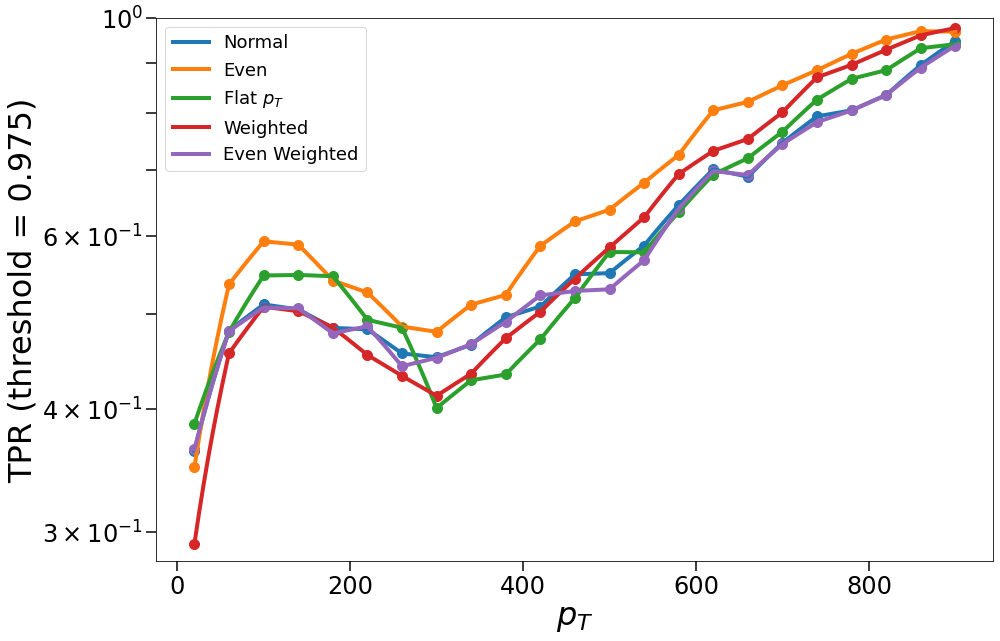

In [153]:
dotsAndCurvePlot([midpoints[0], midpoints[-2]], 
                 [f for f in tpr_fs], 
                 [midpoints[:23]]*len(tprs), 
                 [row[:23] for row in tprs], 
                 names, 
                 f'TPR (threshold = {threshold})', 
                 ylim=None)
plt.ylim(0.28, 1)
plt.yticks(ticks=[i/10 for i in range(3,11)])
plt.savefig(f'./02_24_images/tprs', dpi=200, bbox_inches='tight')

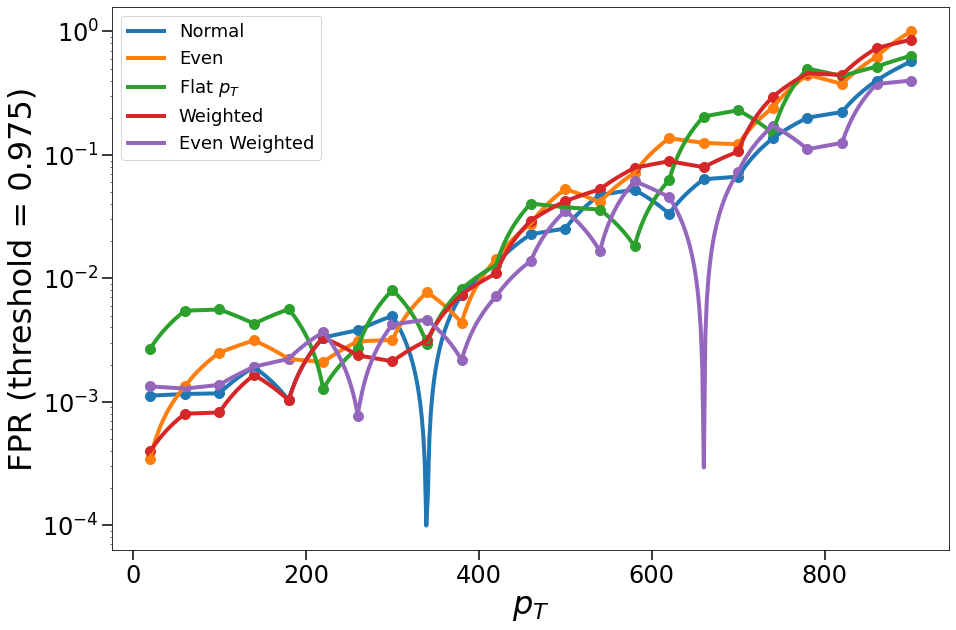

In [148]:
dotsAndCurvePlot([midpoints[0], midpoints[-2]], 
                 [f for f in fpr_fs], 
                 [midpoints[:23]]*len(fprs), 
                 [row[:23] for row in fprs], 
                 names, 
                 f'FPR (threshold = {threshold})', 
                 ylim=None)
plt.savefig(f'./02_24_images/fprs', dpi=200, bbox_inches='tight')

# Understanding New Variables

In [42]:
relevant = np.concatenate([sigInd, bgInd])
relevant_data = data[relevant]

In [56]:
print(f'Shape of relevant_data: {relevant_data.shape}')

Shape of relevant_data: (1310007, 515)


In [154]:
print(len(new_feature_names))

330


In [43]:
t1 = timer()
good_new_feature_names = [
    feature for i, feature in enumerate(new_feature_names) if not np.all(relevant_data[:,len(orig_feature_names)+i] == -100)]
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

duration: 13.93 min


In [44]:
print(f'# of new features: {len(new_feature_names)}; # of non-trivial new features: {len(good_new_feature_names)}')

# of new features: 330; # of non-trivial new features: 175


In [155]:
for feature in good_new_feature_names:
    print(f'"{feature}",')

"numberOfValidHits_1",
"numberOfValidHits_2",
"numberOfValidHits_3",
"numberOfValidHits_4",
"numberOfValidHits_5",
"numberOfValidTrackerHits_1",
"numberOfValidTrackerHits_2",
"numberOfValidTrackerHits_3",
"numberOfValidTrackerHits_4",
"numberOfValidTrackerHits_5",
"numberOfValidPixelHits_1",
"numberOfValidPixelHits_2",
"numberOfValidPixelHits_3",
"numberOfValidPixelHits_4",
"numberOfValidPixelHits_5",
"numberOfValidPixelBarrelHits_1",
"numberOfValidPixelBarrelHits_2",
"numberOfValidPixelBarrelHits_3",
"numberOfValidPixelBarrelHits_4",
"numberOfValidPixelBarrelHits_5",
"numberOfValidPixelEndcapHits_1",
"numberOfValidPixelEndcapHits_2",
"numberOfValidPixelEndcapHits_3",
"numberOfValidPixelEndcapHits_4",
"numberOfValidPixelEndcapHits_5",
"numberOfValidStripHits_1",
"numberOfValidStripHits_2",
"numberOfValidStripHits_3",
"numberOfValidStripHits_4",
"numberOfValidStripHits_5",
"numberOfValidStripTIBHits_1",
"numberOfValidStripTIBHits_2",
"numberOfValidStripTIBHits_3",
"numberOfValidStripTIB

In [45]:
good_feature_indices = [total_feature_names.index(feature) for feature in orig_feature_names + good_new_feature_names]

In [54]:
print(f'Number of good features: {len(good_feature_indices)} (original + good new)')

Number of good features: 360 (original + good new)


In [57]:
t1 = timer()
newX = np.transpose(np.transpose(relevant_data)[good_feature_indices])
newY = np.concatenate([np.ones_like(sigInd), np.zeros_like(bgInd)])
t2 = timer()
print(f'duration: {round((t2-t1)/60,2)} min')

duration: 15.46 min


In [58]:
newX = np.where(newX == -100, np.zeros_like(newX), newX)

In [158]:
for i, name in enumerate(good_new_feature_names):
    with plt.rc_context(settings):
        bins = np.arange(-0.5, np.amax(newX[:,len(orig_feature_names)+i])+0.5, 1)
        pt_hist, _, _ = plt.hist(
            [newX[newY==0, len(orig_feature_names)+i], newX[newY==1, len(orig_feature_names)+i]],
            bins=bins,
            histtype='step',
            label=['Background', 'Signal'], 
            color=['tab:blue', 'tab:red'],
            linewidth=6, 
            density=True)
        plt.legend()
        plt.xlabel(name)
        plt.ylabel(r'a.u.')
        plt.yscale('log')
        plt.savefig(f'./02_24_images/new_feature_histos/{name}', dpi=200, bbox_inches='tight')
        plt.clf()

<Figure size 1080x720 with 0 Axes>

Train on all features?